In [1]:
import sys
from os.path import abspath, join
sys.path.insert(0, abspath('..'))

import logging

import numpy as np
from scipy.sparse import csr_matrix

from sklearn import metrics
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

from evaluate import Evaluate
from space_plot import SpacePlot
from data import load_data
from utils import SphericalKmeans, SphericalKmeansPlus

from tabulate import tabulate

import umap

/home/godwin/Documents/academic/PPD/short-text-clustering/stc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/godwin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/godwin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


>>>>> /home/godwin/Documents/academic/PPD/short-text-clustering/demos
>>>>> data_loader.py cwd:  /home/godwin/Documents/academic/PPD/short-text-clustering/demos


[nltk_data] Downloading package punkt to /home/godwin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
plot = SpacePlot()
eval = Evaluate()

In [3]:
cur = abspath("")
dataset = 'SearchSnippets'
data_in_dir=join(cur, "..", "datasets")
dataset_dir=join(data_in_dir, dataset)
dataset_dir

'/home/godwin/Documents/academic/PPD/short-text-clustering/demos/../datasets/SearchSnippets'

In [4]:

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')
	

In [5]:
###############################################################################
# Data loading
word_emb='HuggingFace'
x, y = load_data(dataset=dataset_dir, word_emb=word_emb, transform=None, scaler=None, norm=None)
n_clusters = len(np.unique(y))

print("%d documents" %  x.shape[0])
print("%d categories" % n_clusters)
print()
print('Original shape:', x.shape, y.shape)

No scaling applied...
12340 documents
8 categories

Original shape: (12340, 384) (12340,)


In [6]:
###############################################################################
# UMAP for dimensionality reduction (and finding dense vectors)
dimred = "UMAP"
print("Performing dimensionality reduction using UMAP")
n_components = 100
u = umap.UMAP(n_components=n_components, n_neighbors=15, min_dist=0.1, metric='cosine')
normalizer = Normalizer(copy=False)
u = make_pipeline(u, normalizer)
zu = u.fit_transform(x)

print()

Performing dimensionality reduction using UMAP



In [7]:
print('Reduced shape:', zu.shape)

# table for results display
table = []

Reduced shape: (12340, 100)


In [8]:
###############################################################################
# Spherical K-Means plus clustering
skmp = SphericalKmeansPlus(n_clusters=n_clusters, max_iter=300, init='k-means++', random_state=1000)
	
print("Clustering with %s" % skmp)
skmp.fit(csr_matrix(zu))
print()

print("Accuracy: %.3f" % eval.accuracy(y, skmp.labels_))
print("Normalized Mutual Information: %.3f" 
	% metrics.normalized_mutual_info_score(y, skmp.labels_))
print("Adjusted Rand-Index: %.3f" 
	% metrics.adjusted_rand_score(y, skmp.labels_))
print("Adjusted Mututal Information: %.3f" 
	% metrics.adjusted_mutual_info_score(y, skmp.labels_))
print("Normalized Mututal Information: %.3f" 
	% metrics.normalized_mutual_info_score(y, skmp.labels_))
print("Silhouette Coefficient (euclidean): %0.3f" 
	% metrics.silhouette_score(zu, skmp.labels_, metric='euclidean'))
print("Silhouette Coefficient (cosine): %0.3f" 
	% metrics.silhouette_score(zu, skmp.labels_, metric='cosine'))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, skmp.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(y, skmp.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(y, skmp.labels_))

print()

table.append([
	'spherical k-means++',
	eval.accuracy(y, skmp.labels_),
	metrics.normalized_mutual_info_score(y, skmp.labels_),
	metrics.adjusted_rand_score(y, skmp.labels_),
	metrics.adjusted_mutual_info_score(y, skmp.labels_),
	metrics.homogeneity_score(y, skmp.labels_),
	metrics.completeness_score(y, skmp.labels_),
	metrics.v_measure_score(y, skmp.labels_),
	metrics.silhouette_score(zu, skmp.labels_, metric='cosine'),
	metrics.silhouette_score(zu, skmp.labels_, metric='euclidean')])

Clustering with <utils.sphericalKmeans_optim.SphericalKMeans object at 0x7f96d6752f90>

Accuracy: 0.818
Normalized Mutual Information: 0.666
Adjusted Rand-Index: 0.644
Adjusted Mututal Information: 0.665
Normalized Mututal Information: 0.666
Silhouette Coefficient (euclidean): 0.460
Silhouette Coefficient (cosine): 0.638
Homogeneity: 0.657
Completeness: 0.674
V-measure: 0.666



In [9]:

###############################################################################
# Print all results in table
headers = [
    f'{word_emb} - {dimred}',
    'Accuracy',
    'Norm MI',
    'Adj Rand',
    'Adj MI',
    'Homogeneity',
    'Completeness',
    'V-Measure',
    'Silhouette (cos)',
    'Silhouette (euc)']

print(tabulate(table, headers, tablefmt="fancy_grid"))

╒══════════════════════╤════════════╤═══════════╤════════════╤══════════╤═══════════════╤════════════════╤═════════════╤════════════════════╤════════════════════╕
│ HuggingFace - UMAP   │   Accuracy │   Norm MI │   Adj Rand │   Adj MI │   Homogeneity │   Completeness │   V-Measure │   Silhouette (cos) │   Silhouette (euc) │
╞══════════════════════╪════════════╪═══════════╪════════════╪══════════╪═══════════════╪════════════════╪═════════════╪════════════════════╪════════════════════╡
│ spherical k-means++  │   0.817909 │  0.665502 │   0.643855 │ 0.665159 │      0.657439 │       0.673766 │    0.665502 │            0.63797 │           0.459583 │
╘══════════════════════╧════════════╧═══════════╧════════════╧══════════╧═══════════════╧════════════════╧═════════════╧════════════════════╧════════════════════╛


# Visualisation

In [24]:
n_components = 3
u = umap.UMAP(n_components=n_components, n_neighbors=15, min_dist=0.1, metric='cosine')
normalizer = Normalizer(copy=False)
u = make_pipeline(u, normalizer)
z = u.fit_transform(x)


In [71]:
normalizer = Normalizer(copy=False)
#u = make_pipeline(normalizer)
#z = u.fit_transform(x)

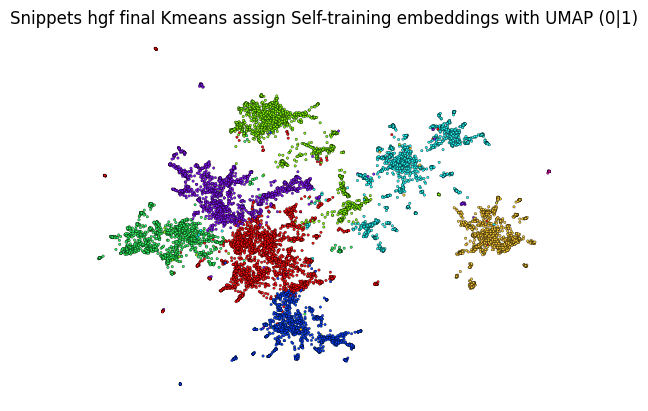

In [75]:
plot.commonSpace_plot(x, comp=[0, 1], tagLabels=skmp.labels_,
                      data_name="Snippets hgf final Kmeans assign", dimred = 'UMAP')

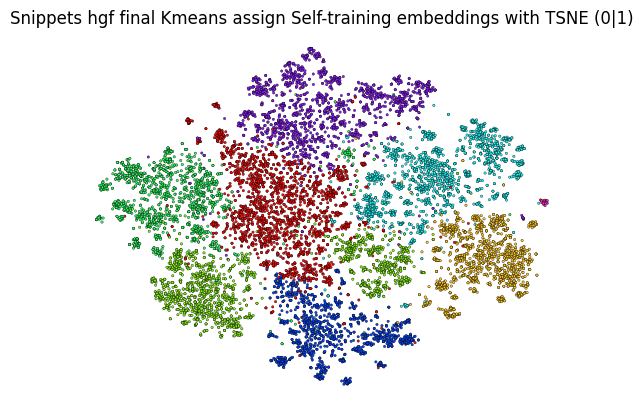

In [76]:
plot.commonSpace_plot(x, comp=[0, 1], tagLabels=skmp.labels_,
                      data_name="Snippets hgf final Kmeans assign", dimred = 'TSNE')

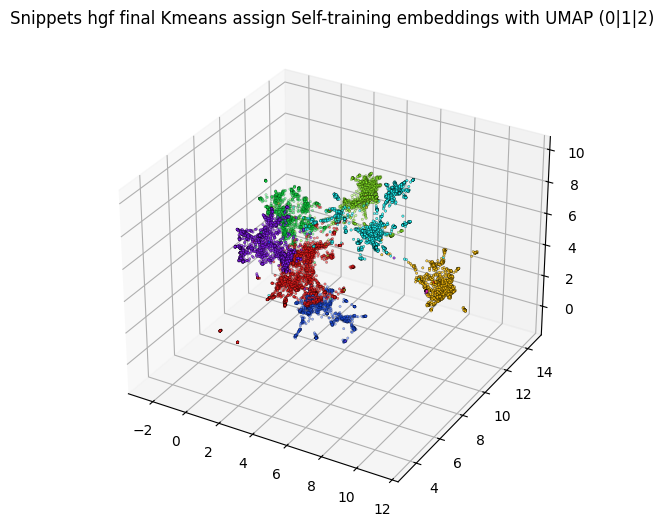

In [81]:
plot.commonSpace_plot(x, comp=[0, 1, 2], tagLabels=skmp.labels_,
                      data_name="Snippets hgf final Kmeans assign", dimred="UMAP")

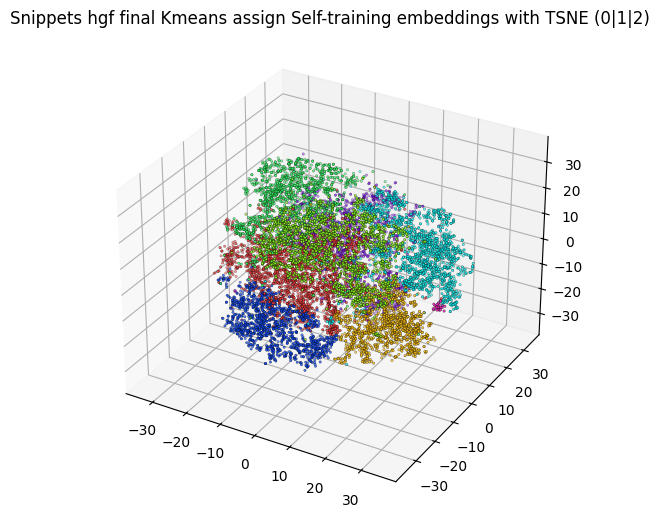

In [79]:
plot.commonSpace_plot(x, comp=[0, 1, 2], tagLabels=skmp.labels_,
                      data_name="Snippets hgf final Kmeans assign", dimred = 'TSNE')

In [13]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # NOQA

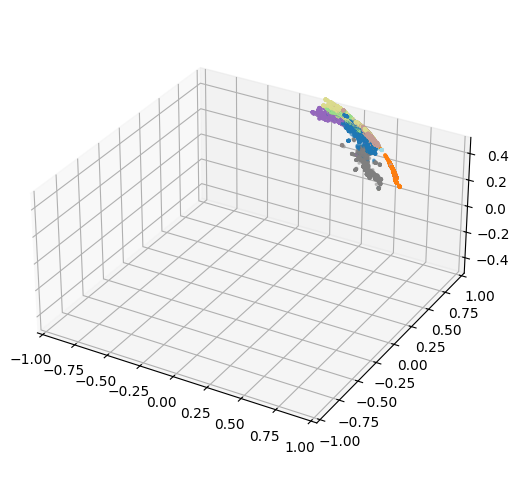

In [59]:
plt.ion()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(
    1, 1, 1, aspect='equal', projection='3d',
    adjustable='box', xlim=[-1, 1], ylim=[-1, 1],
    zlim=[-0.5, 0.5]
)
ax.scatter(z[:, 0], z[:, 1], z[:, 2], c=skmp.labels_, s=3, cmap='tab20')
ax.set_aspect('equal')